<a href="https://colab.research.google.com/github/dipanjannC/Deep-Learning/blob/master/Multi_Layer_Perceptrons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initializations

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

In [4]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, ticks,title, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

In [7]:
print("number of datapoints: ", mnist.train.images.shape[0]," number of pixels in each image: ",mnist.train.images.shape[1])
print("number of datapoints: ", mnist.train.labels.shape[0]," number of labels in dataset: ",mnist.train.labels.shape[1])

number of datapoints:  55000  number of pixels in each image:  784
number of datapoints:  55000  number of labels in dataset:  10


In [0]:
# Network Parameters
n_input = 784
n_classes = 10
n_hidden_1 = 512 # number of neurons in 1st Layer
n_hidden_2 = 128 # number of neurons in 2nd layer

So , our architecture is iike,

    F.C        F.C      SMC(softmax classifier)
728  ---------->  512  ----------->  128 ----------->   10

In [0]:
# Initializing the Placeholders
x = tf.placeholder(tf.float32,[None, 784])  # placeholder for inputs
y_ = tf.placeholder(tf.float32,[None, 10])  # placeholder for actual y_i

#placeholder for dropouts
keep_prob = tf.placeholder(tf.float32)
keep_prob_input = tf.placeholder(tf.float32)


In [11]:
# Weight initialization

# https://arxiv.org/pdf/1707.09725.pdf#page=95
# https://www.tensorflow.org/api_docs/python/tf/random_normal
# Outputs random values from a normal distribution mean=0 std=1

# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1). 
# h1 =>  σ=√(2/(fan_in+fan_out+1) = 0.039  => N(0,σ) = N(0,0.039)
# h2 =>  σ=√(2/(fan_in+fan_out+1) = 0.055  => N(0,σ) = N(0,0.055)
# out =>  σ=√(2/(fan_in+fan_out+1) = 0.120  => N(0,σ) = N(0,0.120)
# SGD: Xavier/Glorot Normal initialization.
weights_sgd = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.039, mean=0)),    #784x512 # sqrt(2/(784+512)) = 0.039
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.055, mean=0)), #512x128 # sqrt(2/(512+128)) = 0.055
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}

# https://arxiv.org/pdf/1707.09725.pdf#page=95
# for relu lates
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
# h1 =>  σ=√(2/(fan_in+1) = 0.062  => N(0,σ) = N(0,0.062)
# h2 =>  σ=√(2/(fan_in+1) = 0.125  => N(0,σ) = N(0,0.125)
# out =>  σ=√(2/(fan_in+1) = 0.120  => N(0,σ) = N(0,0.120)
# He Normal initialization.
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.062, mean=0)),    #784x512
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)), #512x128
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             #512x1
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),             #128x1
    'out': tf.Variable(tf.random_normal([n_classes]))              #10x1
}

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Parameters
training_epochs = 50
learning_rate = 0.001
batch_size = 100
display_step = 1 #i.e after how many steps you want to display your plot,here after each epoch we will display 


# Model 1 : input (784) - sigmoid(512) - sigmoid(128) - softmax(output 10) 

In [0]:
# Create model
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.sigmoid(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

Model 1 with Adam Optimizer

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.682941594 test cost=1.676739588
Epoch: 0002 train cost=1.538383644 test cost=1.536499198
Epoch: 0003 train cost=1.516285429 test cost=1.516714223
Epoch: 0004 train cost=1.504306501 test cost=1.505756942
Epoch: 0005 train cost=1.495986246 test cost=1.498500832
Epoch: 0006 train cost=1.489618614 test cost=1.493705590
Epoch: 0007 train cost=1.484975125 test cost=1.490166647
Epoch: 0008 train cost=1.481422061 test cost=1.487790055
Epoch: 0009 train cost=1.478575771 test cost=1.485733355
Epoch: 0010 train cost=1.476058757 test cost=1.484414918
Epoch: 0011 train cost=1.474140810 test cost=1.483432052
Epoch: 0012 train cost=1.472469109 test cost=1.482476808
Epoch: 0013 train cost=1.471253896 test cost=1.482072009
Epoch: 0014 train cost=1.470228230 test cost=1.481680430
Epoch: 0015 train cost=1.469267078 test cos

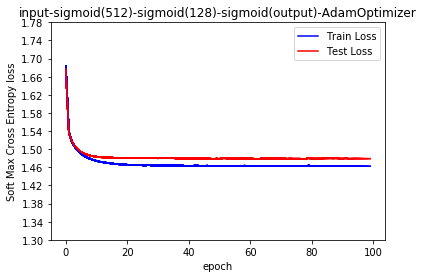

In [30]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
# Computer y_i hat i.e the predicted value
y_sgd = multilayer_perceptron(x,weights_sgd,biases)

#calculating the log loss value i.e cross entropy
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_sgd, labels = y_))

# Initializting the Optimizers
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)


with tf.Session() as sess:
    # initializing all the global variables
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.   
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size) # fetching the no. of batches according to batch_size we initialized earlier

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch # calulating average training loss after each iteration(epoch)
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch # calulating average training loss after each iteration(epoch)

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))



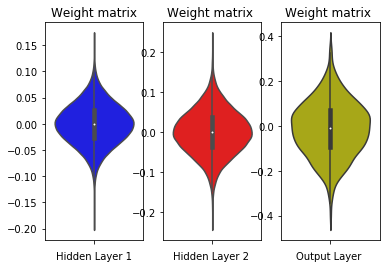

In [27]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**Model 1 with Gradient Decent Optimizer**

Epoch: 0001 train cost=2.321564540 test cost=2.321150202
Epoch: 0002 train cost=2.318521373 test cost=2.318157343
Epoch: 0003 train cost=2.315810137 test cost=2.315517844
Epoch: 0004 train cost=2.313424408 test cost=2.313203239
Epoch: 0005 train cost=2.311333858 test cost=2.311149142
Epoch: 0006 train cost=2.309496613 test cost=2.309346313
Epoch: 0007 train cost=2.307867411 test cost=2.307755907
Epoch: 0008 train cost=2.306409356 test cost=2.306304021
Epoch: 0009 train cost=2.305092844 test cost=2.305030156
Epoch: 0010 train cost=2.303899262 test cost=2.303813533
Epoch: 0011 train cost=2.302816279 test cost=2.302718572
Epoch: 0012 train cost=2.301831965 test cost=2.301750970
Epoch: 0013 train cost=2.300937148 test cost=2.300834191
Epoch: 0014 train cost=2.300127413 test cost=2.300014296
Epoch: 0015 train cost=2.299395790 test cost=2.299252249
Epoch: 0016 train cost=2.298738532 test cost=2.298571920
Epoch: 0017 train cost=2.298147681 test cost=2.297952731
Epoch: 0018 train cost=2.297613

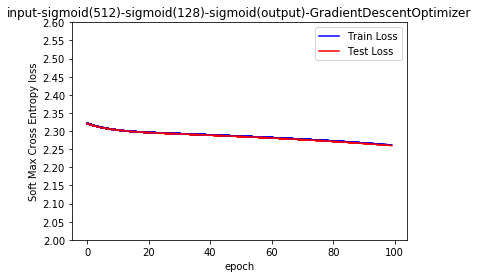

In [31]:
# We can now launch the model in an InteractiveSession

# Note: make sure you initialize variables

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_sgdc, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(2, 2.6, step=0.05), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(2, 2.6, step=0.05), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

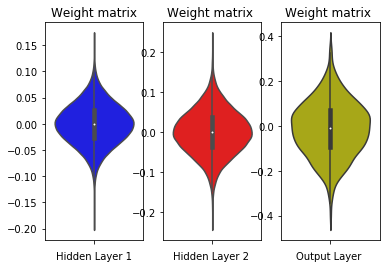

In [28]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

#Model 2: input (784) - ReLu(512) - ReLu(128) - sigmoid(output 10) 

In [0]:
# Create model
def multilayer_perceptron_relu(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.558863960 test cost=1.553809897
Epoch: 0002 train cost=1.500869568 test cost=1.501984452
Epoch: 0003 train cost=1.488610380 test cost=1.492479212
Epoch: 0004 train cost=1.482727066 test cost=1.489153654
Epoch: 0005 train cost=1.478434366 test cost=1.486031231
Epoch: 0006 train cost=1.475590462 test cost=1.484320518
Epoch: 0007 train cost=1.473480541 test cost=1.482918699
Epoch: 0008 train cost=1.472103152 test cost=1.482520484
Epoch: 0009 train cost=1.470486153 test cost=1.481997091
Epoch: 0010 train cost=1.469727064 test cost=1.481558785
Epoch: 0011 train cost=1.468763274 test cost=1.480968859
Epoch: 0012 train cost=1.468208797 test cost=1.481250223
Epoch: 0013 train cost=1.468463499 test cost=1.480946891
Epoch: 0014 train cost=1.467842502 test cost=1.480608781
Epoch: 0015 train cost=1.467086066 test cos

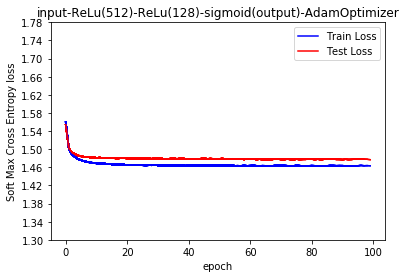

In [33]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
yrelu = multilayer_perceptron_relu(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = yrelu, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)
optimizer_relu_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_relu_adam, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-ReLu(512)-ReLu(128)-sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.3, 1.8, step=0.04), "input-ReLu(512)-ReLu(128)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

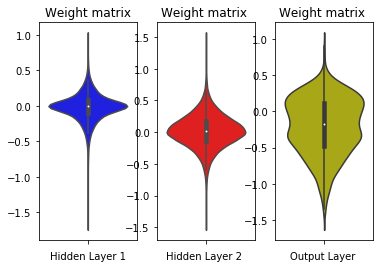

In [34]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**ReLu(512)-ReLu(128)-sigmoid(output) - GradientDescentOptimizer**

Epoch: 0001 train cost=2.321509665 test cost=2.316798456
Epoch: 0002 train cost=2.227539322 test cost=2.219945126
Epoch: 0003 train cost=2.144788755 test cost=2.135815686
Epoch: 0004 train cost=2.067583695 test cost=2.058638025
Epoch: 0005 train cost=1.989005513 test cost=1.979689266
Epoch: 0006 train cost=1.934081882 test cost=1.924469748
Epoch: 0007 train cost=1.895377707 test cost=1.885935935
Epoch: 0008 train cost=1.866585492 test cost=1.857340544
Epoch: 0009 train cost=1.844205585 test cost=1.835351400
Epoch: 0010 train cost=1.826191737 test cost=1.817553650
Epoch: 0011 train cost=1.811140100 test cost=1.802762371
Epoch: 0012 train cost=1.797553562 test cost=1.789487024
Epoch: 0013 train cost=1.781139457 test cost=1.773214935
Epoch: 0014 train cost=1.765221260 test cost=1.757221149
Epoch: 0015 train cost=1.753694408 test cost=1.745608294
Epoch: 0016 train cost=1.743808135 test cost=1.735641602
Epoch: 0017 train cost=1.735142255 test cost=1.726996134
Epoch: 0018 train cost=1.727488

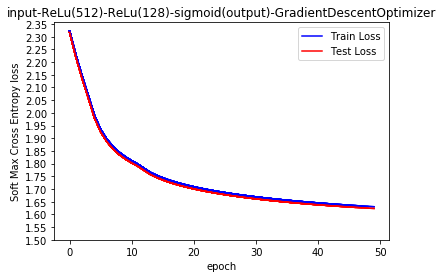

In [37]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:


# Make sure to initialize variables after AdamOptimizer

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_relu_sgdc, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-ReLu(512)-ReLu(128)-sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-ReLu(512)-ReLu(128)-sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

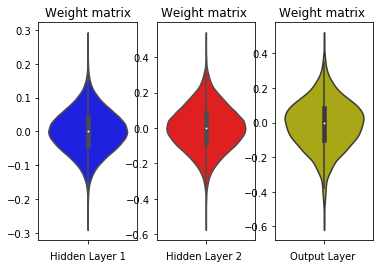

In [39]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**Model 3: Input - Sigmoid(BatchNormalization(512)) - Sigmoid(BatchNormalization(128))- Sigmoid(output)** 

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Sigmoid activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Sigmoid activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    ######################################################################################
    
    # output layer with Sigmoid activation 
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

**Model 3 with Adam Optimizer**

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Instructions for updating:
Use tf.cast instead.
Epoch: 0001 train cost=1.697667968 test cost=1.689333970
Epoch: 0002 train cost=1.554137292 test cost=1.550786987
Epoch: 0003 train cost=1.516122974 test cost=1.515506031
Epoch: 0004 train cost=1.500450389 test cost=1.501982761
Epoch: 0005 train cost=1.491390617 test cost=1.494789489
Epoch: 0006 train cost=1.486090121 test cost=1.491460966
Epoch: 0007 train cost=1.482240193 test cost=1.488212924
Epoch: 0008 train cost=1.478775082 test cost=1.486447946
Epoch: 0009 train cost=1.477364177 test cost=1.485353771
Epoch: 0010 train cost=1.475260521 test cost=1.484205269
Epoch: 0011 train cost=1.473408004 test cost=1.483065278
Epoch: 0012 train cost=1.472226460 test cost=1.482310045
Epoch: 0013 train cost=1.471575944 test cost=1.482188640
Epoch: 0014 train cost=1.470511063 test cost=1.48161

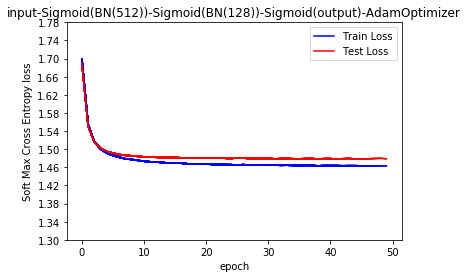

In [41]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

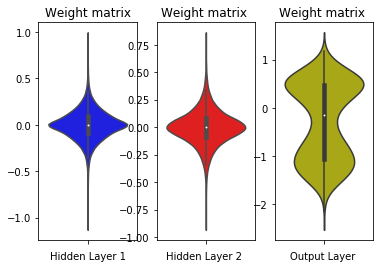

In [42]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model 3 with Gradient Descent Optimizer

Epoch: 0001 train cost=2.319629274 test cost=2.320529026
Epoch: 0002 train cost=2.282610404 test cost=2.282330591
Epoch: 0003 train cost=2.245107988 test cost=2.243535444
Epoch: 0004 train cost=2.210171726 test cost=2.207523905
Epoch: 0005 train cost=2.179199741 test cost=2.175606041
Epoch: 0006 train cost=2.151590070 test cost=2.147420353
Epoch: 0007 train cost=2.126844169 test cost=2.122033668
Epoch: 0008 train cost=2.103964632 test cost=2.098933902
Epoch: 0009 train cost=2.083487102 test cost=2.077934836
Epoch: 0010 train cost=2.064841035 test cost=2.059234300
Epoch: 0011 train cost=2.048718361 test cost=2.042765579
Epoch: 0012 train cost=2.034457644 test cost=2.028455564
Epoch: 0013 train cost=2.021926317 test cost=2.015886191
Epoch: 0014 train cost=2.011060684 test cost=2.004742313
Epoch: 0015 train cost=2.001073343 test cost=1.994707897
Epoch: 0016 train cost=1.991944520 test cost=1.985514876
Epoch: 0017 train cost=1.983510187 test cost=1.977063076
Epoch: 0018 train cost=1.975801

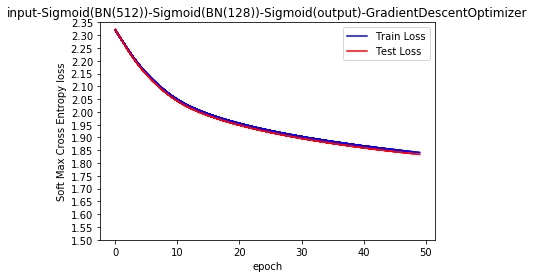

In [43]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.5, 2.4, step=0.05), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

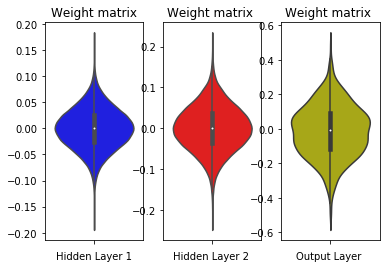

In [44]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**Model 4: Input - Relu(BatchNormalization(512)) - Relu(BatchNormalization(128))- Sigmoid(output)**

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Sigmoid activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.relu(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Sigmoid activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    ######################################################################################
    
    # output layer with Sigmoid activation 
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

Model 4 with Adam Optimizer

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.550719215 test cost=1.542217735
Epoch: 0002 train cost=1.489568850 test cost=1.489876929
Epoch: 0003 train cost=1.480976825 test cost=1.484142343
Epoch: 0004 train cost=1.476471038 test cost=1.481534824
Epoch: 0005 train cost=1.473359068 test cost=1.480400524
Epoch: 0006 train cost=1.471591799 test cost=1.479522575
Epoch: 0007 train cost=1.469827126 test cost=1.479425985
Epoch: 0008 train cost=1.469395839 test cost=1.479432216
Epoch: 0009 train cost=1.468494422 test cost=1.479062848
Epoch: 0010 train cost=1.467538627 test cost=1.478531547
Epoch: 0011 train cost=1.466986813 test cost=1.478505831
Epoch: 0012 train cost=1.466439990 test cost=1.479148156
Epoch: 0013 train cost=1.466226330 test cost=1.477945618
Epoch: 0014 train cost=1.465848802 test cost=1.477917459
Epoch: 0015 train cost=1.465735627 test cos

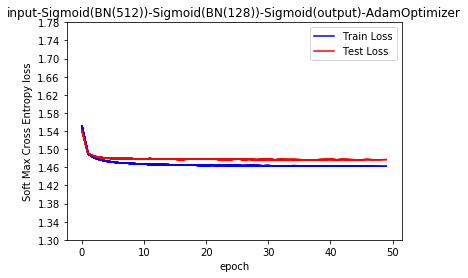

In [46]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

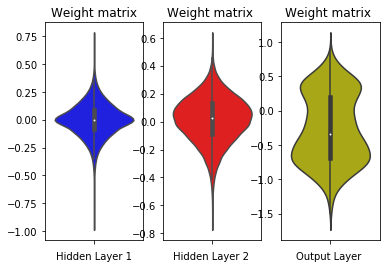

In [47]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()


Model 5: Input - ReLu(512) - Dropout - ReLu(128)- Dropout -Sigmoid(output) 

In [0]:
# Create model
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_1_drop = tf.nn.dropout(layer_1, keep_prob)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2_drop, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

Model 5 with Adam Optimizer

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.681832925 test cost=1.606635197
Epoch: 0002 train cost=1.551047493 test cost=1.517656306
Epoch: 0003 train cost=1.526984276 test cost=1.504301678
Epoch: 0004 train cost=1.516647001 test cost=1.497379170
Epoch: 0005 train cost=1.508817648 test cost=1.493293790
Epoch: 0006 train cost=1.505042977 test cost=1.490217356
Epoch: 0007 train cost=1.501550822 test cost=1.488461393
Epoch: 0008 train cost=1.499076786 test cost=1.486802942
Epoch: 0009 train cost=1.495452141 test cost=1.485375289
Epoch: 0010 train cost=1.493345639 test cost=1.484503217
Epoch: 0011 train cost=1.491519288 test cost=1.484214500
Epoch: 0012 train cost=1.490384412 test cost=1.483649907
Epoch: 0013 train cost=1.489159080 test co

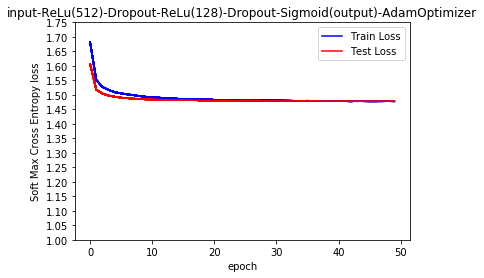

In [49]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))

Text(0.5, 0, 'Output Layer ')

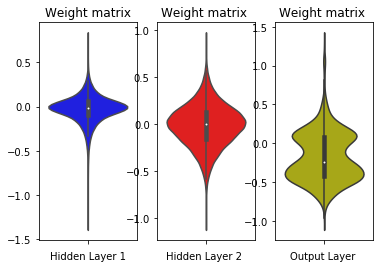

In [50]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

Model 5 with Gradient Descent Optimizer

Epoch: 0001 train cost=2.351351624 test cost=2.288414428
Epoch: 0002 train cost=2.332448987 test cost=2.245839302
Epoch: 0003 train cost=2.317554019 test cost=2.202834569
Epoch: 0004 train cost=2.295161830 test cost=2.162967884
Epoch: 0005 train cost=2.278270715 test cost=2.126778153
Epoch: 0006 train cost=2.259247027 test cost=2.092971966
Epoch: 0007 train cost=2.242815813 test cost=2.060136531
Epoch: 0008 train cost=2.223841978 test cost=2.028235423
Epoch: 0009 train cost=2.206814452 test cost=1.997872828
Epoch: 0010 train cost=2.191098039 test cost=1.970249225
Epoch: 0011 train cost=2.173336912 test cost=1.945720117
Epoch: 0012 train cost=2.155574023 test cost=1.924572270
Epoch: 0013 train cost=2.138279614 test cost=1.905943175
Epoch: 0014 train cost=2.123277424 test cost=1.889735693
Epoch: 0015 train cost=2.106722210 test cost=1.875608641
Epoch: 0016 train cost=2.092734625 test cost=1.862984594
Epoch: 0017 train cost=2.079439771 test cost=1.852312246
Epoch: 0018 train cost=2.066472

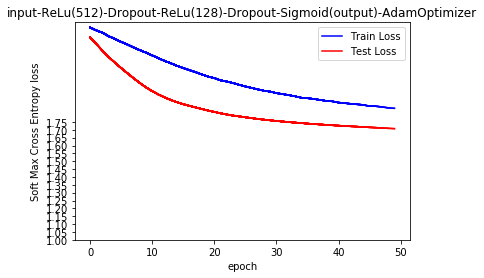

In [51]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))

Text(0.5, 0, 'Output Layer ')

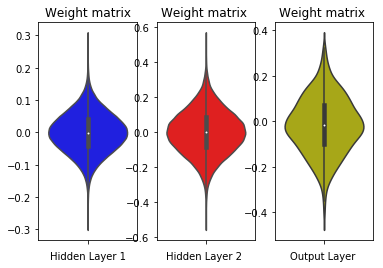

In [52]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()